# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import pmdarima as pm
from pasture_predict.data import create_data_set,clean_dataset

# Generar Data Set (Viejo, funciones en utils)

In [155]:
df_feat = pd.read_csv("../raw_data/lote_prueba3.csv")

In [156]:
df_feat.head(8)

,YEAR,DOY,CLRSKY_SFC_PAR_TOT,T2M,TS,PRECTOTCORR,GWETTOP,GWETROOT
0,2002,42,140.01,23.39,23.58,1.85,0.62,0.64
1,2002,43,147.80,24.95,26.33,0.10,0.61,0.64
2,2002,44,146.81,25.32,26.83,0.00,0.60,0.63
3,2002,45,138.27,24.28,25.45,0.21,0.60,0.62
4,2002,46,150.99,18.94,20.37,0.00,0.60,0.62
5,2002,47,149.26,19.06,20.64,0.00,0.59,0.62
6,2002,48,146.24,20.17,21.83,0.00,0.59,0.62
7,2002,49,138.82,19.68,20.49,0.38,0.58,0.62


In [34]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7432 entries, 0 to 7431
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YEAR                7432 non-null   int64  
 1   DOY                 7432 non-null   int64  
 2   CLRSKY_SFC_PAR_TOT  7432 non-null   float64
 3   T2M                 7432 non-null   float64
 4   TS                  7432 non-null   float64
 5   PRECTOTCORR         7432 non-null   float64
 6   GWETTOP             7432 non-null   float64
 7   GWETROOT            7432 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 464.6 KB


In [157]:
df_feat = df_feat.rename(columns={'CLRSKY_SFC_PAR_TOT':'rad', 
                        'T2M':'temp_2m',
                        'TS':'temp_sup',
                        'GWETTOP':'hum_arriba',
                        'GWETROOT':'hum_raiz',
                        'PRECTOTCORR':'precip'}) 

In [36]:
np.arange(len(df_feat))//8

array([  0,   0,   0, ..., 928, 928, 928])

In [37]:
df_feat_8d = df_feat.groupby(np.arange(len(df_feat))//8).agg({
    'rad': 'sum',
    'temp_2m': 'mean',
    'temp_sup': 'mean',
    'hum_arriba': 'mean',
    'hum_raiz': 'mean',
    'precip': 'sum',    
}, axis=1)

In [158]:
df_feat['date'] = pd.to_datetime(df_feat['YEAR'] * 1000 + df_feat['DOY'], format='%Y%j')

In [64]:
df_feat.index=df_feat['date']
df_feat_M = df_feat.groupby(pd.Grouper(freq='M')).agg({
    'rad': 'sum',
    'temp_2m': 'mean',
    'temp_sup': 'mean',
    'hum_arriba': 'mean',
    'hum_raiz': 'mean',
    'precip': 'sum',    
}, axis=1)

In [65]:
df_feat_M.head(20)

,rad,temp_2m,temp_sup,hum_arriba,hum_raiz,precip
date,,,,,,
2002-02-28,2514.24,22.088889,23.018333,0.617222,0.630556,85.11
2002-03-31,3643.97,18.247097,18.344194,0.803226,0.774839,312.50
2002-04-30,2619.76,13.630667,13.305333,0.859667,0.840000,103.01
2002-05-31,1936.10,11.958710,11.611290,0.885161,0.874194,135.05
2002-06-30,1551.53,5.843000,5.348333,0.889667,0.891667,6.58
2002-07-31,1724.82,6.850323,6.534839,0.886452,0.881290,36.17
2002-08-31,2149.06,10.005484,9.842258,0.882903,0.870968,105.36
2002-09-30,3087.85,10.803333,10.898000,0.874000,0.861667,73.86
2002-10-31,4071.75,15.299032,15.279032,0.844516,0.823548,175.85


In [66]:
pd.to_datetime(f'{df_feat_M.index[:][1]}-{df_feat_M.index[:][0]}-01')

Timestamp('2002-03-31 00:00:00-0100', tz='pytz.FixedOffset(-60)')

In [67]:
df_feat_M.head(20)

,rad,temp_2m,temp_sup,hum_arriba,hum_raiz,precip
date,,,,,,
2002-02-28,2514.24,22.088889,23.018333,0.617222,0.630556,85.11
2002-03-31,3643.97,18.247097,18.344194,0.803226,0.774839,312.50
2002-04-30,2619.76,13.630667,13.305333,0.859667,0.840000,103.01
2002-05-31,1936.10,11.958710,11.611290,0.885161,0.874194,135.05
2002-06-30,1551.53,5.843000,5.348333,0.889667,0.891667,6.58
2002-07-31,1724.82,6.850323,6.534839,0.886452,0.881290,36.17
2002-08-31,2149.06,10.005484,9.842258,0.882903,0.870968,105.36
2002-09-30,3087.85,10.803333,10.898000,0.874000,0.861667,73.86
2002-10-31,4071.75,15.299032,15.279032,0.844516,0.823548,175.85


In [68]:
df_feat_8d.head()

,rad,temp_2m,temp_sup,hum_arriba,hum_raiz,precip
0,1158.20,21.97375,23.1900,0.59875,0.62625,2.54
1,1105.74,21.81500,22.6350,0.60875,0.62250,37.50
2,1026.02,20.71125,21.0575,0.70250,0.69625,90.46
3,964.98,20.35375,20.4225,0.78500,0.74875,88.47
4,928.79,18.13750,18.1975,0.85250,0.81125,67.59


In [69]:
df_result = df_feat_8d.groupby(np.arange(len(df_feat_8d))//8).agg({
            'rad': 'sum',
            'temp_2m': 'mean',
            'temp_sup': 'mean',
            'hum_arriba': 'mean',
            'hum_raiz': 'mean',
            'precip': 'sum',
        }, axis=1)

SyntaxError: unmatched ')' (3362197796.py, line 1)

In [ ]:
df_feat_8d.head(20)

In [ ]:
#plt.figure(figsize=(16,9))
#plt.plot(df.CLRSKY_SFC_PAR_TOT[:-1000], label='Radiacion')

In [ ]:
#plt.figure(figsize=(16,9))
#plt.plot(df.T2M[:-1000], label='Temp 2m')

In [ ]:
#plt.figure(figsize=(16,9))
#plt.plot(df.PRECTOTCORR[:-1000], label='Temp 2m')

In [130]:
df_past = pd.read_csv("../raw_data/prueba_punto_productividad.csv")

In [131]:
df_past.head()

,system:index,first,.geo
0,2002_02_18_0,0.0508,"{""type"":""Point"",""coordinates"":[-58.52642552110..."
1,2002_02_26_0,0.0381,"{""type"":""Point"",""coordinates"":[-58.52642552110..."
2,2002_03_06_0,0.0397,"{""type"":""Point"",""coordinates"":[-58.52642552110..."
3,2002_03_14_0,0.0402,"{""type"":""Point"",""coordinates"":[-58.52642552110..."
4,2002_03_22_0,0.0000,"{""type"":""Point"",""coordinates"":[-58.52642552110..."


In [132]:
df_past = df_past.rename(columns={'system:index':'date', 'first':'prod'})
df_past = df_past.drop('.geo',1)

/tmp/ipykernel_10817/2674065925.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_past = df_past.drop('.geo',1)


In [133]:
df_past.head()

,date,prod
0,2002_02_18_0,0.0508
1,2002_02_26_0,0.0381
2,2002_03_06_0,0.0397
3,2002_03_14_0,0.0402
4,2002_03_22_0,0.0000


In [134]:
df_past.date = df_past.date.apply(lambda s: datetime.date(int(s[0:4]),int(s[5:7]),int(s[8:10])))

In [135]:
df_past.head()

,date,prod
0,2002-02-18,0.0508
1,2002-02-26,0.0381
2,2002-03-06,0.0397
3,2002-03-14,0.0402
4,2002-03-22,0.0000


In [77]:
df_total = pd.concat([df_feat_8d,df_past], axis=1)

In [137]:
df_past2 = df_past.copy()

In [138]:
df_past2.head()

,date,prod
0,2002-02-18,0.0508
1,2002-02-26,0.0381
2,2002-03-06,0.0397
3,2002-03-14,0.0402
4,2002-03-22,0.0000


In [139]:
df_past2.date = pd.to_datetime(df_past2.date)
df_past2 = df_past2.set_index('date')


In [148]:
df_past2.head()

,date,prod
0,2002-02-18,0.0508
1,2002-02-26,0.0381
2,2002-03-06,0.0397
3,2002-03-14,0.0402
4,2002-03-22,0.0000


In [172]:
for index, row in df_past2.iterrows():
    for index2,row2 in df_feat.iterrows():
        if row2.date == row.date:            
            df_past2.loc[index,'rad'] = df_feat.loc[index2-7:index2+1,'rad'].sum()
            df_past2.loc[index,'temp_2m'] = df_feat.loc[index-7:index+1,'temp_2m'].mean()
            df_past2.loc[index,'temp_sup'] = df_feat.loc[index-7:index+1,'temp_sup'].mean()
            df_past2.loc[index,'hum_arriba'] = df_feat.loc[index-7:index+1,'hum_arriba'].mean()
            df_past2.loc[index,'hum_raiz'] = df_feat.loc[index-7:index+1,'hum_raiz'].mean()
            df_past2.loc[index,'precip'] = df_feat.loc[index-7:index+1,'precip'].sum()

In [173]:
df_past2.head()

,date,prod,rad,temp_2m,temp_sup,hum_arriba,hum_raiz,precip
0,2002-02-18,0.0508,1295.75,24.170000,24.955000,0.615000,0.640000,1.95
1,2002-02-26,0.0381,1227.61,24.553333,25.580000,0.610000,0.636667,1.95
2,2002-03-06,0.0397,1149.14,24.485000,25.547500,0.607500,0.632500,2.16
3,2002-03-14,0.0402,1078.33,23.376000,24.512000,0.606000,0.630000,2.16
4,2002-03-22,0.0000,1042.03,22.656667,23.866667,0.603333,0.628333,2.16


In [176]:
df_nino.date = pd.to_datetime(df_nino.date)

In [179]:
df_2merg2 = pd.merge(df_past2.assign(grouper=df_past2['date'].dt.to_period('M')),
                   df_nino.assign(grouper=df_nino['date'].dt.to_period('M')),
                   on='grouper', how='inner')

In [183]:
df_2merg2.columns

Index(['date_x', 'prod', 'rad', 'temp_2m', 'temp_sup', 'hum_arriba',
       'hum_raiz', 'precip', 'grouper', 'date_y', 'ENSOIndex', 'ENSOType'],
      dtype='object')

In [184]:
df_2merg2 =df_2merg2.drop('date_y',1)


/tmp/ipykernel_10817/3973764216.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_2merg2 =df_2merg2.drop('date_y',1)


In [185]:
df_2merg2 = df_2merg2.rename(columns={'date_x':'date'})

In [186]:
df_2merg2.head()

,date,prod,rad,temp_2m,temp_sup,hum_arriba,hum_raiz,precip,grouper,ENSOIndex,ENSOType
0,2002-02-18,0.0508,1295.75,24.170000,24.955000,0.615000,0.640000,1.95,2002-02,0.0,...
1,2002-02-26,0.0381,1227.61,24.553333,25.580000,0.610000,0.636667,1.95,2002-02,0.0,...
2,2002-03-06,0.0397,1149.14,24.485000,25.547500,0.607500,0.632500,2.16,2002-03,0.1,...
3,2002-03-14,0.0402,1078.33,23.376000,24.512000,0.606000,0.630000,2.16,2002-03,0.1,...
4,2002-03-22,0.0000,1042.03,22.656667,23.866667,0.603333,0.628333,2.16,2002-03,0.1,...


In [91]:
df_past2 = df_past2.groupby(pd.Grouper(freq='M')).sum()

In [92]:
df_past2.head()

,prod
date,
2002-02-28,0.0889
2002-03-31,0.1142
2002-04-30,0.0546
2002-05-31,0.0694
2002-06-30,0.0405


In [93]:
f_1merg = pd.merge(left=df_feat_M,right=df_past2, on='date', how='inner')

In [94]:
f_1merg.head()

,rad,temp_2m,temp_sup,hum_arriba,hum_raiz,precip,prod
date,,,,,,,
2002-02-28,2514.24,22.088889,23.018333,0.617222,0.630556,85.11,0.0889
2002-03-31,3643.97,18.247097,18.344194,0.803226,0.774839,312.50,0.1142
2002-04-30,2619.76,13.630667,13.305333,0.859667,0.840000,103.01,0.0546
2002-05-31,1936.10,11.958710,11.611290,0.885161,0.874194,135.05,0.0694
2002-06-30,1551.53,5.843000,5.348333,0.889667,0.891667,6.58,0.0405


In [ ]:
df_total.head(20)

In [ ]:
df_total['ym'] = df_total.date.apply(lambda d: str(d.year) + '-' + str(d.month))

In [ ]:
#plt.figure(figsize=(16,9))
#plt.plot(df_past.iloc[:,1], label='Productividad')

In [ ]:
df_total.info()

In [ ]:
df_total.head(30)

In [96]:
df_nino = pd.read_csv("../raw_data/ENSO.csv")

In [97]:
df_nino.head()

,date,ENSOIndex,ENSOType
0,2022-7,0.0,...
1,2022-6,0.0,ML ...
2,2022-5,0.0,ML ...
3,2022-4,-1.1,ML ...
4,2022-3,-1.0,ML ...


In [ ]:
df_nino.info()

In [ ]:
df_nino = df_nino.rename(columns={'date': 'ym'})

In [ ]:
df_nino.ym = df_nino.ym.astype('string')

In [ ]:
df_final = pd.merge(left=df_total,right=df_nino, on='ym', how='inner')

In [ ]:
df_final = df_final.drop('ym',1)

In [ ]:
df_final.date =  pd.to_datetime(df_final.date)
df_final = df_final[df_final.date < '2022-02-20']

In [ ]:
df_final = df_final.set_index('date')

In [ ]:
df_final.tail(20)

In [ ]:
df_final.to_csv('../raw_data/data_set_completo_Latitude -36.4041 Longitude -58.5546.csv')

In [102]:
df_nino2 = df_nino.copy()

In [103]:
df_nino2.head()

,date,ENSOIndex,ENSOType
0,2022-7,0.0,...
1,2022-6,0.0,ML ...
2,2022-5,0.0,ML ...
3,2022-4,-1.1,ML ...
4,2022-3,-1.0,ML ...


In [104]:
df_nino2.date = pd.to_datetime(df_nino2.date)

In [105]:
df_nino2.head()

,date,ENSOIndex,ENSOType
0,2022-07-01,0.0,...
1,2022-06-01,0.0,ML ...
2,2022-05-01,0.0,ML ...
3,2022-04-01,-1.1,ML ...
4,2022-03-01,-1.0,ML ...


In [111]:
f_1merg = f_1merg.reset_index()

In [112]:
f_1merg.head()

,date,rad,temp_2m,temp_sup,hum_arriba,hum_raiz,precip,prod
0,2002-02-28,2514.24,22.088889,23.018333,0.617222,0.630556,85.11,0.0889
1,2002-03-31,3643.97,18.247097,18.344194,0.803226,0.774839,312.50,0.1142
2,2002-04-30,2619.76,13.630667,13.305333,0.859667,0.840000,103.01,0.0546
3,2002-05-31,1936.10,11.958710,11.611290,0.885161,0.874194,135.05,0.0694
4,2002-06-30,1551.53,5.843000,5.348333,0.889667,0.891667,6.58,0.0405


In [115]:
f_2merg = pd.merge(f_1merg.assign(date=f_1merg['date'].dt.to_period('M')),
                   df_nino2.assign(date=df_nino2['date'].dt.to_period('M')),               
                   on='date', how='inner')

In [117]:
f_2merg.head()

,date,rad,temp_2m,temp_sup,hum_arriba,hum_raiz,precip,prod,ENSOIndex,ENSOType
0,2002-02,2514.24,22.088889,23.018333,0.617222,0.630556,85.11,0.0889,0.0,...
1,2002-03,3643.97,18.247097,18.344194,0.803226,0.774839,312.50,0.1142,0.1,...
2,2002-04,2619.76,13.630667,13.305333,0.859667,0.840000,103.01,0.0546,0.2,...
3,2002-05,1936.10,11.958710,11.611290,0.885161,0.874194,135.05,0.0694,0.4,...
4,2002-06,1551.53,5.843000,5.348333,0.889667,0.891667,6.58,0.0405,0.7,...


# EDA

## 8D

In [6]:
#df = pd.read_csv('../raw_data/data_set_completo_Latitude -36.4041 Longitude -58.5546.csv')
df_sl = pd.read_csv("../raw_data/dataset_completo_sanluis.csv")
df_vi = pd.read_csv("../raw_data/dataset_completo_vieytes.csv")

In [7]:
df_sl = clean_dataset(df_sl)
df_vi = clean_dataset(df_vi)

/home/lucianov84/code/dvtorrez42/pasture_predict/pasture_predict/data.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rad[df.rad < 0] = np.nan
/home/lucianov84/code/dvtorrez42/pasture_predict/pasture_predict/data.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.temp_2m[(df.temp_2m < -50) | (df.temp_2m < -50)] = np.nan
/home/lucianov84/code/dvtorrez42/pasture_predict/pasture_predict/data.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

In [8]:
df_sl.head()

,date,prod,rad,temp_2m,temp_sup,hum_arriba,hum_raiz,precip,ENSOIndex,ENSOType
0,2002-02-18,0.0188,897.16,23.635000,25.480000,0.405,0.410000,2.25,0.0,...
1,2002-02-26,0.0200,1103.71,24.470000,26.306667,0.390,0.406667,2.25,0.0,...
2,2002-03-06,0.0195,1077.18,24.932500,26.665000,0.380,0.405000,2.27,0.1,...
3,2002-03-14,0.0111,958.57,24.880000,26.572000,0.376,0.404000,2.80,0.1,...
4,2002-03-22,0.0000,727.95,24.521667,26.061667,0.395,0.405000,18.61,0.1,...


In [9]:
df_sl.tail()

,date,prod,rad,temp_2m,temp_sup,hum_arriba,hum_raiz,precip,ENSOIndex,ENSOType
930,2022-05-09,0.0091,1255.28,8.642222,9.217778,0.48,0.446667,NaN,0.0,ML ...
931,2022-05-17,0.0067,1255.28,8.642222,9.217778,0.48,0.446667,NaN,0.0,ML ...
932,2022-05-25,0.0048,1255.28,8.642222,9.217778,0.48,0.446667,NaN,0.0,ML ...
933,2022-06-02,0.0071,1255.28,8.642222,9.217778,0.48,0.446667,NaN,0.0,ML ...
934,2022-06-10,0.0064,1255.28,8.642222,9.217778,0.48,0.446667,NaN,0.0,ML ...


In [31]:
df_sl.date =  pd.to_datetime(df_sl.date)
df_vi.date =  pd.to_datetime(df_vi.date)

In [32]:
df_sl = df_sl[df_sl.date < '2022-02-20']
df_vi = df_vi[df_vi.date < '2022-02-20']

In [12]:
df_sl.columns

Index(['date', 'prod', 'rad', 'temp_2m', 'temp_sup', 'hum_arriba', 'hum_raiz',
       'precip', 'ENSOIndex', 'ENSOType'],
      dtype='object')

In [13]:
df_sl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 921 entries, 0 to 920
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        921 non-null    object 
 1   prod        921 non-null    float64
 2   rad         921 non-null    float64
 3   temp_2m     921 non-null    float64
 4   temp_sup    921 non-null    float64
 5   hum_arriba  921 non-null    float64
 6   hum_raiz    921 non-null    float64
 7   precip      921 non-null    float64
 8   ENSOIndex   921 non-null    float64
 9   ENSOType    921 non-null    object 
dtypes: float64(8), object(2)
memory usage: 79.1+ KB


In [14]:
df_sl.shape[0]

921

In [16]:
df_sl.describe()

,prod,rad,temp_2m,temp_sup,hum_arriba,hum_raiz,precip,ENSOIndex
count,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000
mean,0.013392,878.673225,16.423313,17.091712,0.404134,0.402392,14.132866,0.021498
std,0.007347,351.470551,6.355751,7.158125,0.066675,0.033699,19.898004,0.795623
min,0.000000,217.550000,4.870000,4.214444,0.207778,0.330000,0.000000,-1.700000
25%,0.007000,539.710000,10.582222,10.427778,0.368889,0.380000,0.410000,-0.500000
50%,0.012300,872.360000,16.546667,17.282222,0.403333,0.401111,4.160000,0.000000
75%,0.019000,1214.950000,22.210000,23.608889,0.450000,0.421111,21.700000,0.500000
max,0.037300,1522.110000,28.286667,30.310000,0.587778,0.510000,101.480000,2.600000


/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='rad'>

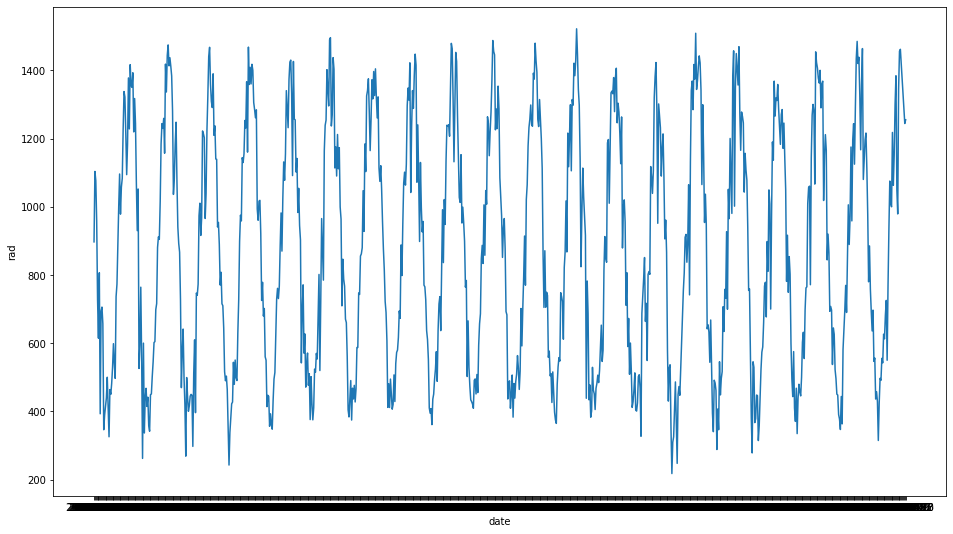

In [22]:
plt.figure(figsize=(16,9))
sns.lineplot(df_sl.date,df_sl.rad)

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='temp_2m'>

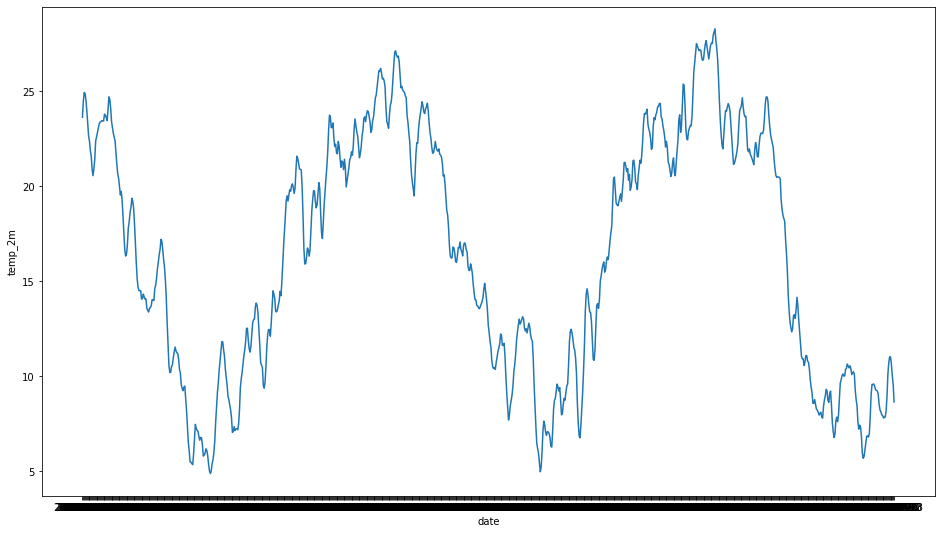

In [23]:
plt.figure(figsize=(16,9))
sns.lineplot(df_sl.date,df_sl.temp_2m)

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='temp_sup'>

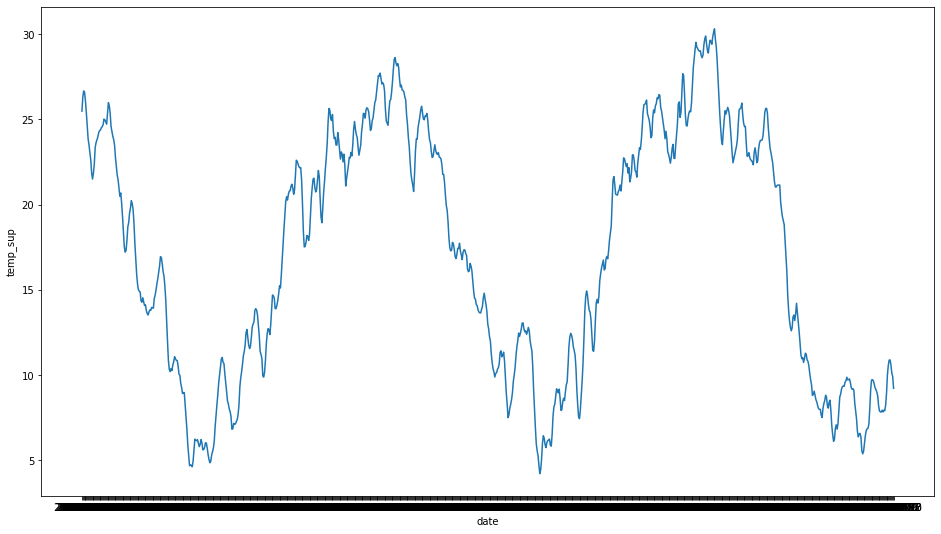

In [25]:
plt.figure(figsize=(16,9))
sns.lineplot(df_sl.date,df_sl.temp_sup)

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='hum_arriba'>

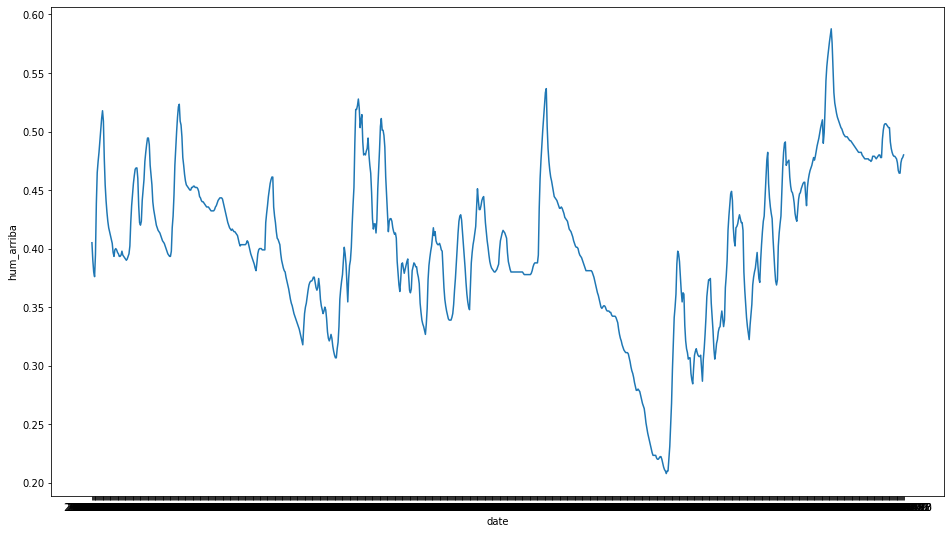

In [26]:
plt.figure(figsize=(16,9))
sns.lineplot(df_sl.date,df_sl.hum_arriba)

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='hum_raiz'>

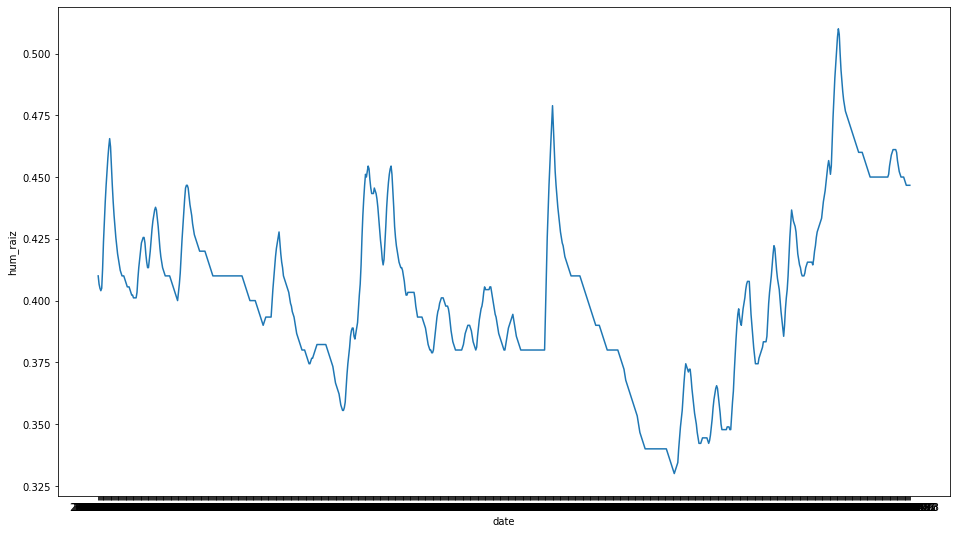

In [27]:
plt.figure(figsize=(16,9))
sns.lineplot(df_sl.date,df_sl.hum_raiz)

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='prod'>

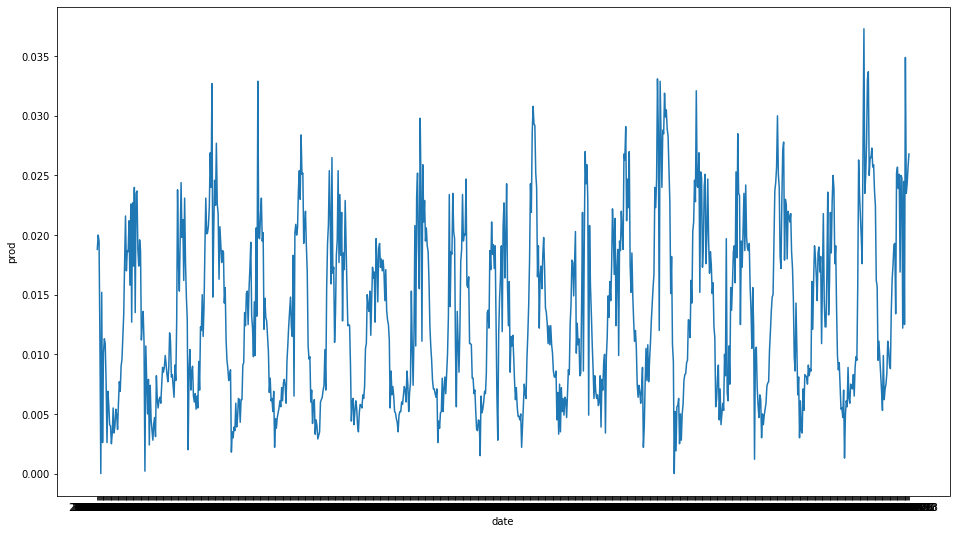

In [29]:
plt.figure(figsize=(16,9))
sns.lineplot(df_sl.date,df_sl['prod'])

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'radiacion por año')

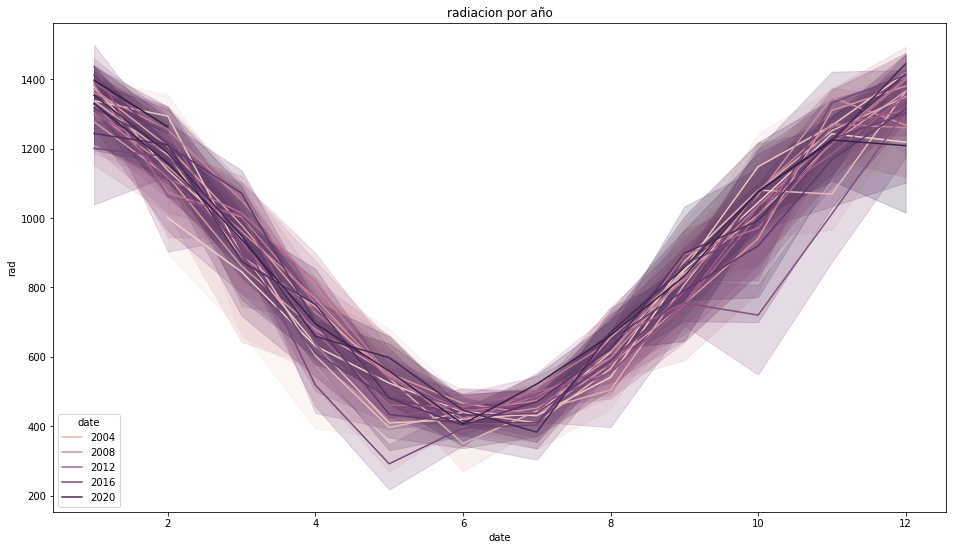

In [33]:
plt.figure(figsize=(16,9))
sns.lineplot(df_sl.date.dt.month,df_sl.rad,hue=df_sl.date.dt.year)
plt.title('radiacion por año')

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'temperatura 2m por año')

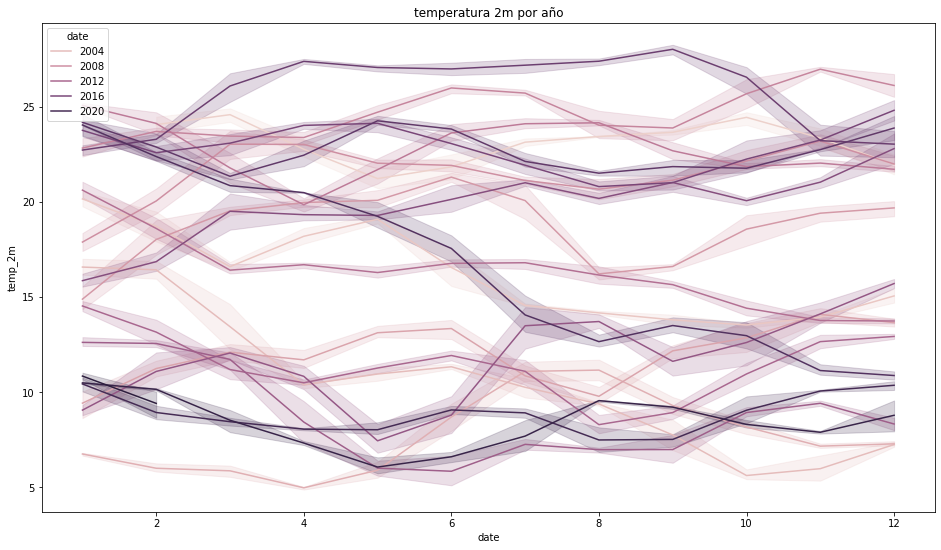

In [36]:
plt.figure(figsize=(16,9))
sns.lineplot(df_sl.date.dt.month,df_sl.temp_2m,hue=df_sl.date.dt.year)
plt.title('temperatura 2m por año')

In [39]:
df_sl.describe()

,prod,rad,temp_2m,temp_sup,hum_arriba,hum_raiz,precip,ENSOIndex
count,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000
mean,0.013392,878.673225,16.423313,17.091712,0.404134,0.402392,14.132866,0.021498
std,0.007347,351.470551,6.355751,7.158125,0.066675,0.033699,19.898004,0.795623
min,0.000000,217.550000,4.870000,4.214444,0.207778,0.330000,0.000000,-1.700000
25%,0.007000,539.710000,10.582222,10.427778,0.368889,0.380000,0.410000,-0.500000
50%,0.012300,872.360000,16.546667,17.282222,0.403333,0.401111,4.160000,0.000000
75%,0.019000,1214.950000,22.210000,23.608889,0.450000,0.421111,21.700000,0.500000
max,0.037300,1522.110000,28.286667,30.310000,0.587778,0.510000,101.480000,2.600000


/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'temperatura superficie por año')

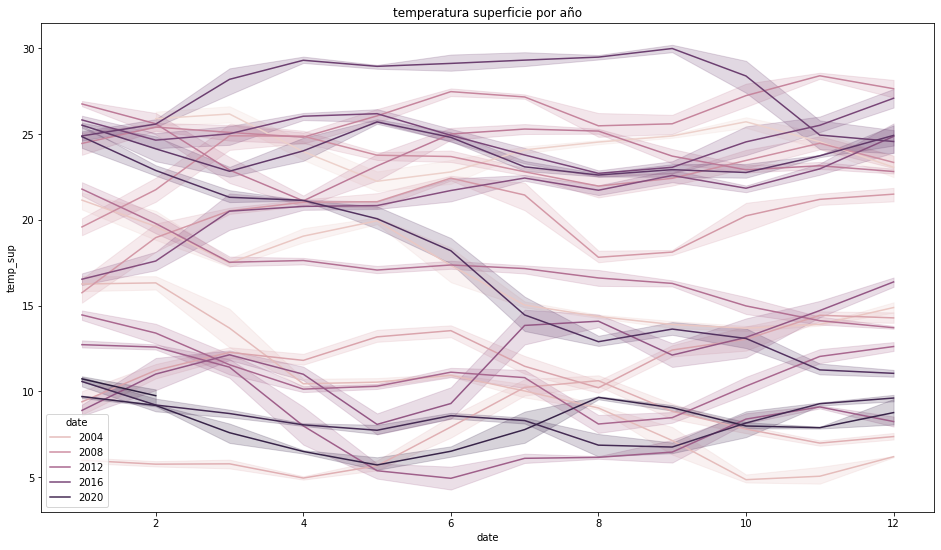

In [37]:
plt.figure(figsize=(16,9))
sns.lineplot(df_sl.date.dt.month,df_sl.temp_sup,hue=df_sl.date.dt.year)
plt.title('temperatura superficie por año')

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='prod'>

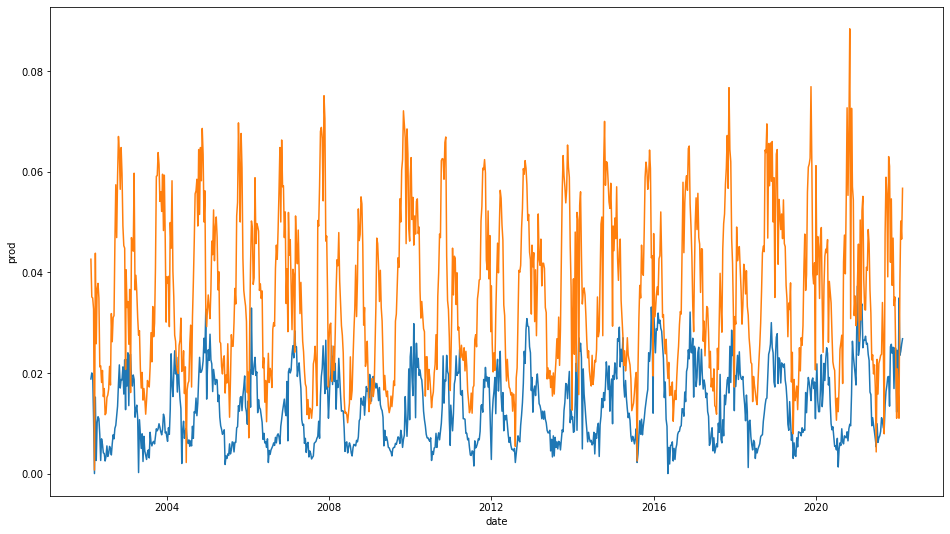

In [41]:
plt.figure(figsize=(16,9))
sns.lineplot(df_sl.date,df_sl['prod'])
sns.lineplot(df_vi.date,df_vi['prod'])

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='prod'>

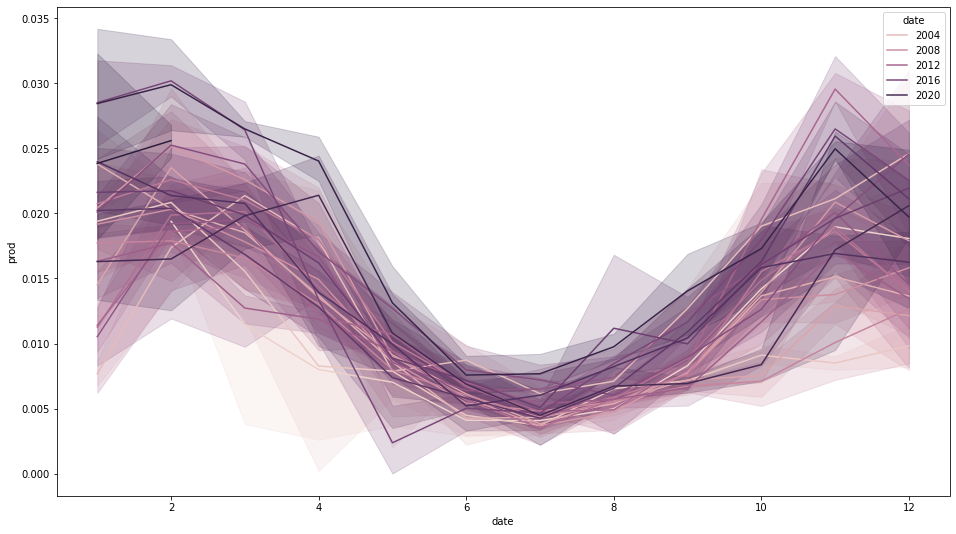

In [43]:
plt.figure(figsize=(16,9))
sns.lineplot(df_sl.date.dt.month,df_sl['prod'],hue=df_sl.date.dt.year)

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='prod'>

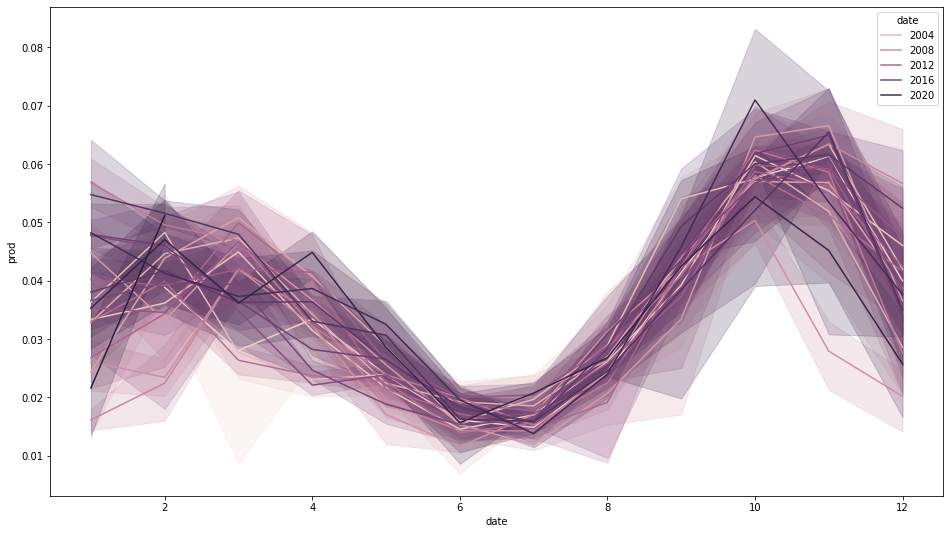

In [42]:
plt.figure(figsize=(16,9))
sns.lineplot(df_vi.date.dt.month,df_vi['prod'],hue=df_vi.date.dt.year)

<AxesSubplot:xlabel='prod', ylabel='Count'>

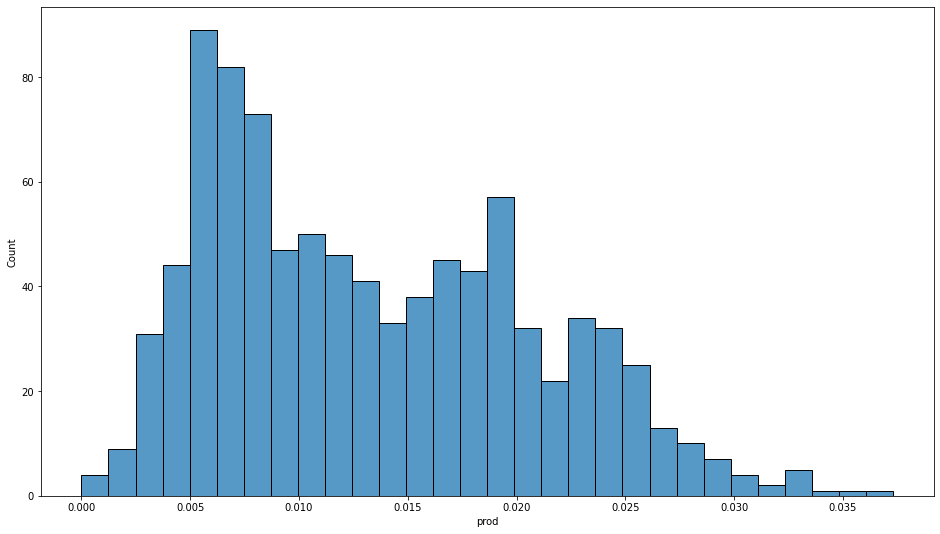

In [44]:
plt.figure(figsize=(16,9))
sns.histplot(df_sl['prod'], bins=30)

<AxesSubplot:>

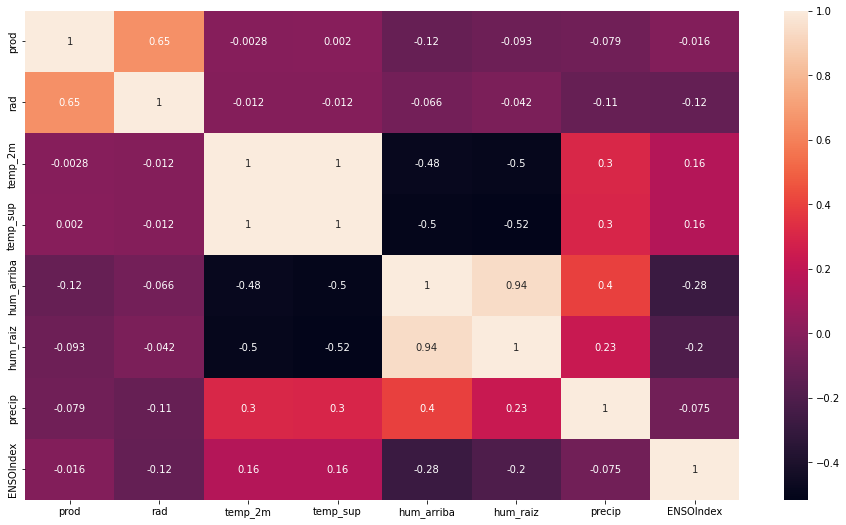

In [45]:
plt.figure(figsize=(16,9))
sns.heatmap(df_sl.corr(),annot=True)

<AxesSubplot:>

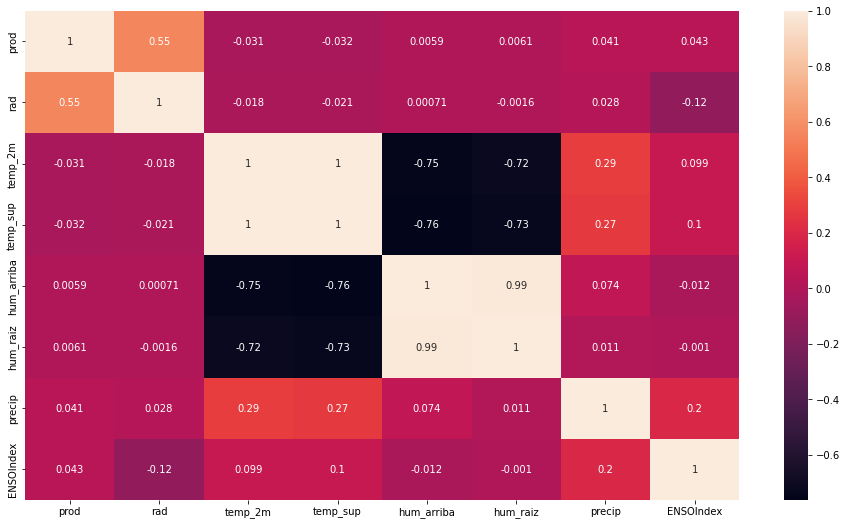

In [46]:
plt.figure(figsize=(16,9))
sns.heatmap(df_vi.corr(),annot=True)

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ENSOIndex', ylabel='prod'>

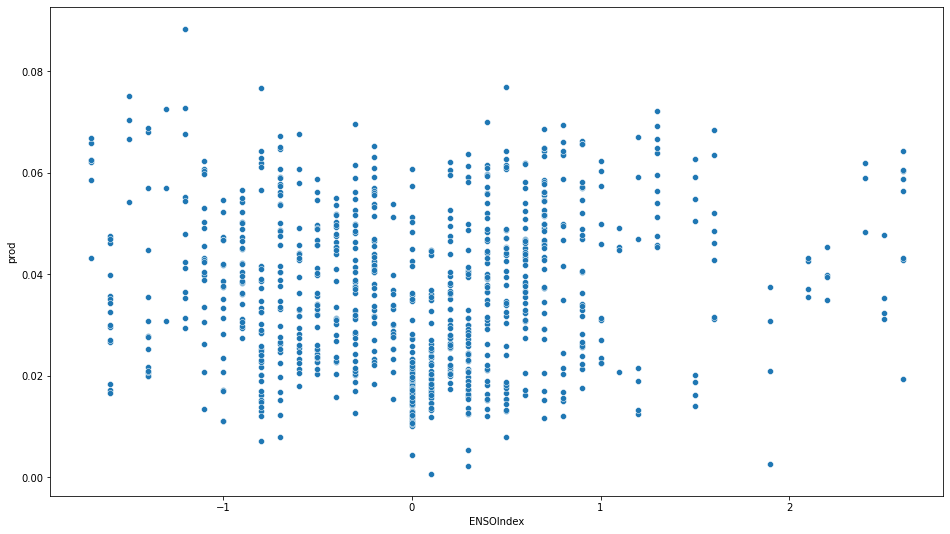

In [47]:
plt.figure(figsize=(16,9))
sns.scatterplot(df_vi.ENSOIndex,df_vi['prod'])

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ENSOType', ylabel='prod'>

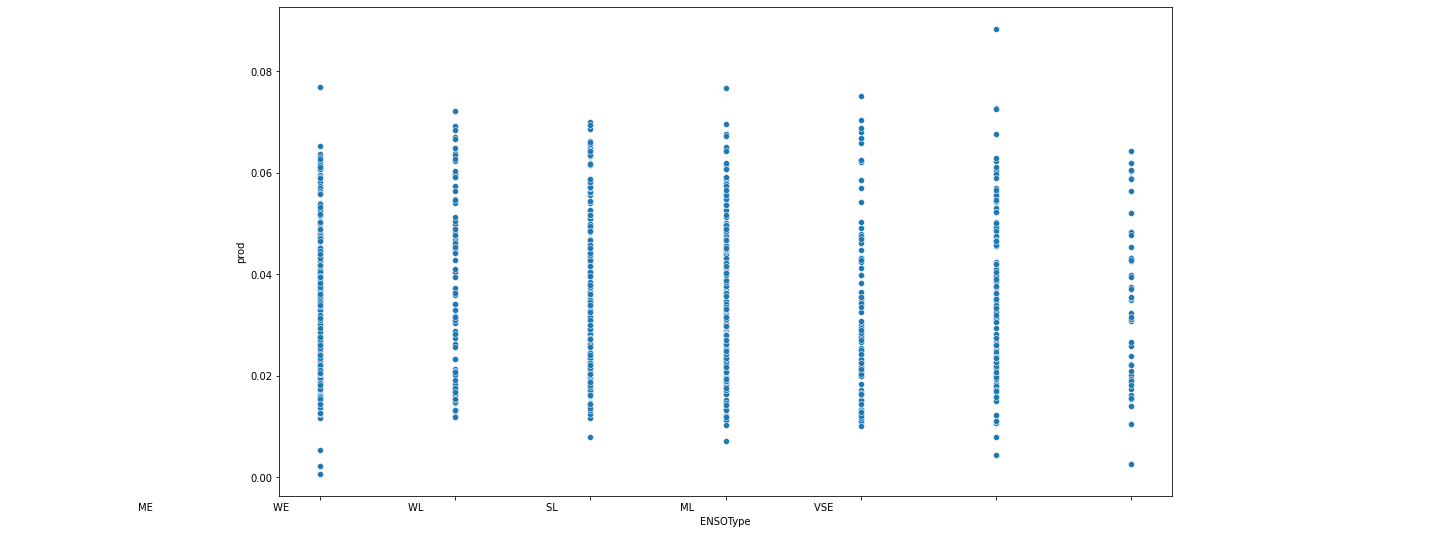

In [48]:
plt.figure(figsize=(16,9))
sns.scatterplot(df_vi.ENSOType,df_vi['prod'])

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='ENSOType', ylabel='prod'>

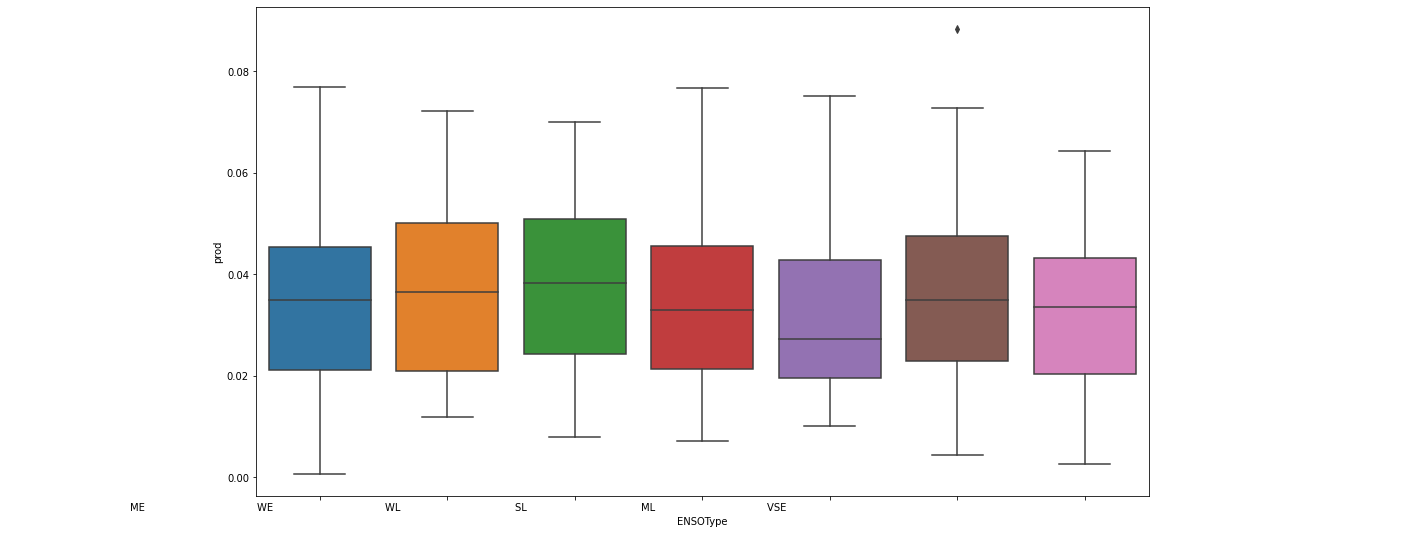

In [49]:
plt.figure(figsize=(16,9))
sns.boxplot(df_vi.ENSOType,df_vi['prod'])

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='precip', ylabel='prod'>

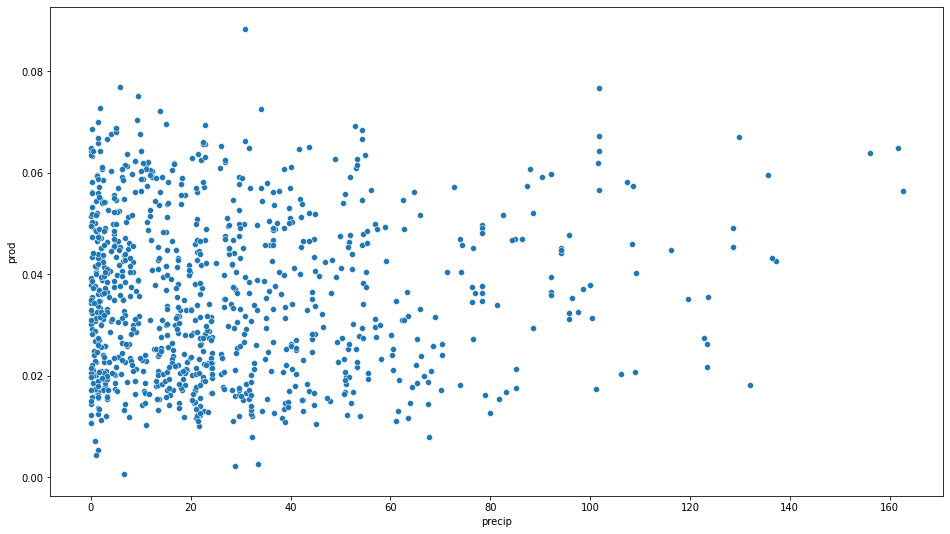

In [50]:
plt.figure(figsize=(16,9))
sns.scatterplot(df_vi.precip,df_vi['prod'])

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rad', ylabel='prod'>

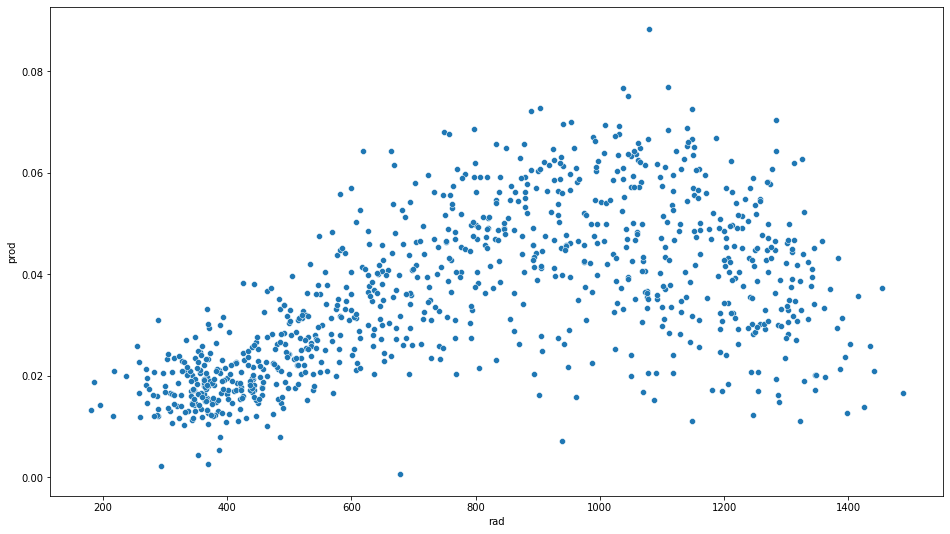

In [51]:
plt.figure(figsize=(16,9))
sns.scatterplot(df_vi.rad,df_vi['prod'])

##  Train Test Split

In [54]:
train_size = 22
#index = round(train_size*df.shape[0])
df_sl_train = df_sl.iloc[:-train_size]
df_sl_test = df_sl.iloc[-train_size:]

df_vi_train = df_vi.iloc[:-train_size]
df_vi_test = df_vi.iloc[-train_size:]

##  Preproc

In [61]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()



## Decomposition

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose

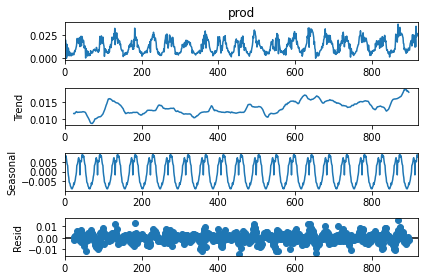

In [60]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(df_sl['prod'], model='additive', period=46)
result_add.plot();

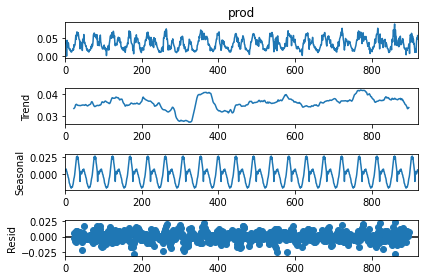

In [61]:
result_add = seasonal_decompose(df_vi['prod'], model='additive', period=46)
result_add.plot();

In [63]:
# prod Decomposition (y = Trend + Seasonal + Residuals)
result_mul = seasonal_decompose(df_sl['prod'], model='multiplicative', period=46)
result_mul.plot();

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

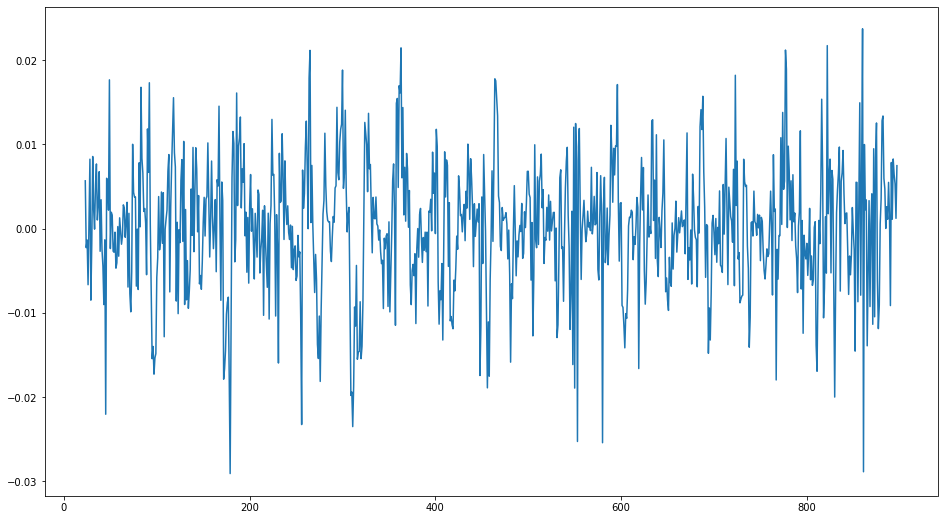

In [64]:
plt.figure(figsize=(16,9))
plt.plot(result_add.resid);

In [78]:
print('add resid: ', adfuller(result_add.resid.dropna())[1])

add resid:  5.609805356911515e-18


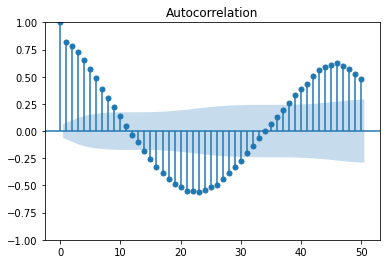

In [68]:
plot_acf(df_sl['prod'], lags=50)
plt.show()

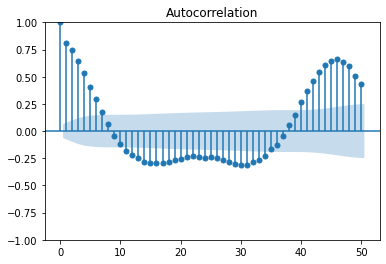

In [69]:
plot_acf(df_vi['prod'], lags=50)
plt.show()

In [72]:
q_sl = 9
q_vi = 7

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


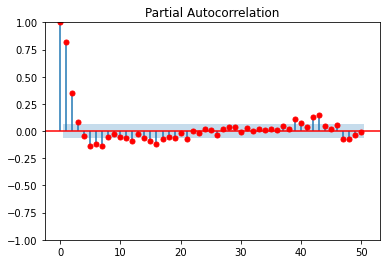

In [71]:
plot_pacf(df_sl['prod'], lags=50, c='r');

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


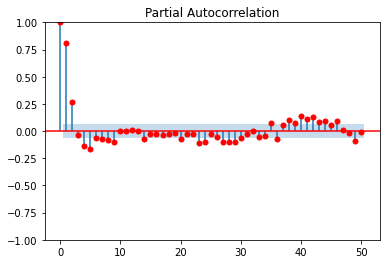

In [73]:
plot_pacf(df_vi['prod'], lags=50, c='r');

In [79]:
p_sl = 2
p_vie = 2

In [ ]:
smodel_sl = pm.auto_arima(df_sl_train['prod'], seasonal=True, m=46, 
                       start_p=p_sl, max_p=10, max_d=1, start_q=q_sl, max_q=10,
                       start_P=0, max_P=1, max_D=1, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[46] intercept   : AIC=-7409.126, Time=1.59 sec
 ARIMA(0,0,0)(0,0,0)[46] intercept   : AIC=-6297.152, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[46] intercept   : AIC=inf, Time=9.09 sec
 ARIMA(0,0,1)(0,0,1)[46] intercept   : AIC=-6925.448, Time=11.43 sec
 ARIMA(0,0,0)(0,0,0)[46]             : AIC=-4988.298, Time=0.08 sec
 ARIMA(2,0,2)(1,0,0)[46] intercept   : AIC=-7104.552, Time=24.25 sec
 ARIMA(2,0,2)(0,0,1)[46] intercept   : AIC=-7446.936, Time=30.57 sec
 ARIMA(2,0,2)(1,0,1)[46] intercept   : AIC=inf, Time=22.54 sec
 ARIMA(2,0,2)(0,0,2)[46] intercept   : AIC=-7449.092, Time=118.58 sec
 ARIMA(2,0,2)(1,0,2)[46] intercept   : AIC=inf, Time=60.78 sec
 ARIMA(1,0,2)(0,0,2)[46] intercept   : AIC=-7477.264, Time=50.88 sec
 ARIMA(1,0,2)(0,0,1)[46] intercept   : AIC=-7458.513, Time=9.45 sec
 ARIMA(1,0,2)(1,0,2)[46] intercept   : AIC=inf, Time=97.96 sec
 ARIMA(1,0,2)(1,0,1)[46] intercept   : AIC=inf, Time=13.25 sec
 ARIMA(0,0,2)(0,0,2)[46] 

In [115]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Build Model
sarima = SARIMAX(df_sl_train['prod'], order=(0, 0, 1), seasonal_order=(1, 0, 1, 46))
sarima = sarima.fit(maxiter=500)

# Forecast
results = sarima.get_forecast(22, alpha=0.05)
forecast = results.predicted_mean
confidence_int = results.conf_int()

/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/lucianov84/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.77124D+01    |proj g|=  3.01037D+02

At iterate    5    f= -9.10497D-01    |proj g|=  6.82137D+00

At iterate   10    f= -9.88942D-01    |proj g|=  8.34823D-01

At iterate   15    f= -9.99968D-01    |proj g|=  1.37707D+00

At iterate   20    f= -1.07894D+00    |proj g|=  4.83956D-01

At iterate   25    f= -1.08480D+00    |proj g|=  5.86654D-02

At iterate   30    f= -1.09969D+00    |proj g|=  7.44146D-01

At iterate   35    f= -1.56110D+00    |proj g|=  7.16544D+00

At iterate   40    f= -1.57168D+00    |proj g|=  8.07479D+00

At iterate   45    f= -2.03500D+00    |proj g|=  2.10163D+00

At iterate   50    f= -2.10051D+00    |proj g|=  3.16105D+00

At iterate   55    f= -2.13564D+00    |proj g|=  5.62152D+00

At iterate   60    f= -2.14402D+00    |proj g|=  5.20325D-02

At iterate   65    f= -2.1

In [116]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

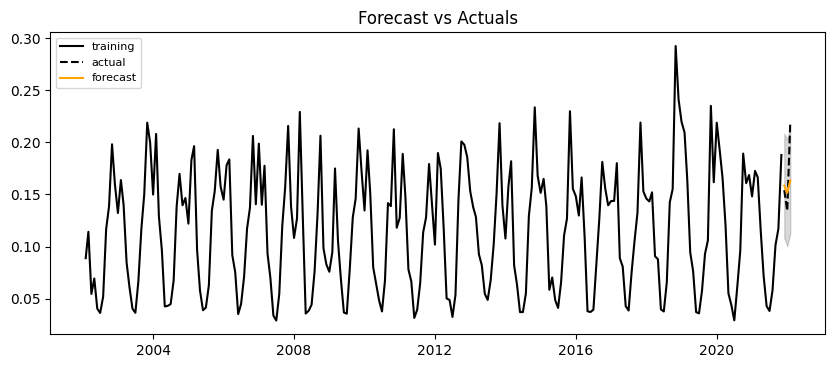

In [118]:
forecast_recons = pd.Series(forecast, index=y_test.index)
lower_recons = confidence_int['lower prod'].values
upper_recons = confidence_int['upper prod'].values

plot_forecast(forecast_recons, y_train, y_test, upper = upper_recons, lower=lower_recons)

# ML

In [ ]:
df2_sl = df_sl['prod'].copy()
for i in range(1, 47):
    df2_sl[f'x_{i}'] = df2_sl["prod"].shift(i)

# Drop nan
df2_sl = df2_sl.dropna()

# create df_train and df_test 
df2_sl_train = df2_sl[:-22]
df2_sl_test = df2_sl[-22:]

In [ ]:
test_indexes = np.arange(len(df2_sl_train), len(df2_sl_train)+len(df2_sl_test))
test_indexes

In [ ]:
y = df2_sl['prod']
X = df2_sl.drop(columns=['prod'])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor(n_estimators=20, random_state=0)

In [ ]:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [ ]:
results = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X.values)

In [ ]:
print('Mean Absolute Prediction Error MAPE')
results[2]

In [ ]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

In [ ]:
df2_sl["ewma_2"] = df2_sl["prod"].ewm(halflife=2).mean()
df2_sl["ewma_3"] = df2_sl["prod"].ewm(halflife=3).mean()
df2_sl["ewma_12"] = df2_sl["prod"].ewm(halflife=12).mean()

In [ ]:
random_forest = RandomForestRegressor(n_estimators=20, random_state=12)
features = ["ewma_2", "ewma_3", "ewma_12", "ma_2", "ma_3", "ma_12", "x_1","x_2","x_3","x_4","x_5",
                   "x_6","x_7","x_8","x_9","x_10","x_11","x_12"]
new_features = df2[features].fillna(0).values

results2 = evaluate_performance_month_prediction(df2["prod"].values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = new_features)